📘 **Note Format Guide**

This format serves as a structured guide for organizing lecture content, personal interpretation, experiments, and study-related questions.

| Type | What It Means | When I Use It |
|------|----------------|----------------|
| 📝 Lecture | Original material from the professor’s notes | When I’m referencing core concepts or provided code |
| 🗣️ In-Class Note | Verbal explanations shared during the lecture | When I want to record something the professor said in class but didn’t include in the official notes |
| ✍️ My Note | My thoughts, interpretations, or additional explanations | When I reflect on or explain something in my own words |
| 🔬 Experiment | Code I tried out or changed to explore further | When I test variations or go beyond the original example |
| ❓ Question | Questions I had while studying | When I want to revisit or research something more deeply |

📝
🗣️
✍️
🔬
❓

# 1. 강의노트 원본 및 영상 링크

[https://guebin.github.io/DL2025/posts/06wk-1.html](https://guebin.github.io/DL2025/posts/06wk-1.html)

# 2. Imports 📝

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 데이터분석 코딩패턴 📝

In [3]:
# 복습
# --- 
# 시벤코정리 - 다 맞출수있어 (train) 
# 오버피팅 - 그게 의미가 없을텐데 (test 에서 잘하는게 의미가 있다) 
# 드랍아웃 - 대충대충 학습하면 오히려 좋을지도 --> 이게 성공함 // 랜덤포레스트?
#----#
# GPU 메모리 아깝다.. (비싸거든) 
# 그래서 확률적경사하강법 
# 꼭 돈이 없어서 이 알고리즘을 만든것 같지만 그런건 아님 
# 확률적경사하강법은 알고리즘 자체에 장점이 있음 
# -- 장점1: 데이터를 조금씩쓰면서 update // 대충대충하는 느낌 ---> 오버핏을 눌러주는 효과 // 배깅?
# -- 장점2: global min 이 있고, local min 있을때, local min을 잘 탈출하는 효과가 있음 

🗣️ 랜덤포레스트: node를 몇 개 선택하여 학습 / 배깅: obs를 몇 개 선택하여 학습

In [4]:
# 오늘할것: train/test 이 존재하는 데이터 셋팅에서 Dropout 레이어도 쓰고, 미니배치도 쓰고.. GPU도 쓰고.. 

## A. 일반적인 train/test 셋팅

`-` Step1: 데이터정리

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==0])
X1 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
XX0 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==0])
XX1 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==1])
XX = torch.concat([XX0,XX1],axis=0).reshape(-1,784)
yy = torch.tensor([0.0]*len(XX0) + [1.0]*len(XX1)).reshape(-1,1)

🗣️(

In [6]:
X[0].shape

torch.Size([784])

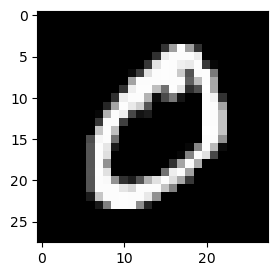

In [7]:
plt.imshow(X[0].reshape(28,28), cmap="gray")

In [9]:
print(y[0]) # label이 tensor 형태로 저장되어 있음

tensor([0.])


- X만 가지고 학습을 한 뒤 XX를 가지고 확인

In [10]:
X.shape, y.shape

(torch.Size([12665, 784]), torch.Size([12665, 1]))

In [11]:
XX.shape, yy.shape

(torch.Size([2115, 784]), torch.Size([2115, 1]))

)🗣️

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [12]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(), # (n,32)
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid() # y는 0 또는 1
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters()) # Adam은 너무 잘 맞춰서 SGD

`-` Step3: 학습 (=적합)

In [13]:
for epoc in range(1,501):
    #---에폭시작---# 
    # 1 
    yhat = net(X) 
    # 2 
    loss = loss_fn(yhat,y) 
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
    #---에폭끝---# 
    #에폭마다 내가 보고싶은것들을 보여주는 코드
    if (epoc % 50) ==0: # 50으로 나눈 나머지 = 0 => 50의 배수
        acc = ((net(X).data > 0.5) == y).float().mean().item() # item: tensor -> float
        print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")

# of epochs=50   	 train_acc = 0.4677
# of epochs=100   	 train_acc = 0.4677
# of epochs=150   	 train_acc = 0.4757
# of epochs=200   	 train_acc = 0.5295
# of epochs=250   	 train_acc = 0.6632
# of epochs=300   	 train_acc = 0.7929
# of epochs=350   	 train_acc = 0.8731
# of epochs=400   	 train_acc = 0.9206
# of epochs=450   	 train_acc = 0.9465
# of epochs=500   	 train_acc = 0.9634


🗣️ 오버피팅 비판 가능성 존재

`-` Step4: 예측 & 결과분석 

*train acc*

In [14]:
((net(X).data > 0.5) == y).float().mean()

tensor(0.9634)

*test acc*

In [15]:
((net(XX).data>0.5) == yy).float().mean()

tensor(0.9749)

🗣️ 실전에서 더 괜찮음

🗣️ Step4: acc, recall, F1 score, 시각화 등

```python
#에폭마다 내가 보고싶은것들을 보여주는 코드
    if (epoc % 50) ==0: # 50으로 나눈 나머지 = 0 => 50의 배수
        acc = ((net(X).data > 0.5) == y).float().mean().item() # item: tensor -> float
        Xval --> # train data 자체에서 test 데이터를 나누고 정확도를 비교하며 early stopping 할 수도 있음 (오버피팅 방지)
        print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")
```

## B. Dropout 사용 

`-` Step1: 데이터정리

In [16]:
pass

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [17]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters())

🗣️ 원래는 활성화 함수 다음이지만 ReLU 한정 전에도 사용 가능

`-` Step3: 학습 (=적합)

In [18]:
for epoc in range(1,501):
    net.train()
    #---에폭시작---# 
    # 1 
    yhat = net(X) 
    # 2 
    loss = loss_fn(yhat,y) 
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
    #---에폭끝---# 
    net.eval()
    #에폭마다 내가 보고싶은것들을 보여주는 코드
    if (epoc % 50) ==0:
        acc = ((net(X).data > 0.5) == y).float().mean().item()
        print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")

# of epochs=50   	 train_acc = 0.4677
# of epochs=100   	 train_acc = 0.4677
# of epochs=150   	 train_acc = 0.4744
# of epochs=200   	 train_acc = 0.5215
# of epochs=250   	 train_acc = 0.6435
# of epochs=300   	 train_acc = 0.7675
# of epochs=350   	 train_acc = 0.8468
# of epochs=400   	 train_acc = 0.8978
# of epochs=450   	 train_acc = 0.9301
# of epochs=500   	 train_acc = 0.9492


In [19]:
# of epochs=50   	 train_acc = 0.4677
# of epochs=100   	 train_acc = 0.4677
# of epochs=150   	 train_acc = 0.4757 # 위의 결과와 살짝 다름
# of epochs=200   	 train_acc = 0.5295
# of epochs=250   	 train_acc = 0.6632
# of epochs=300   	 train_acc = 0.7929
# of epochs=350   	 train_acc = 0.8731
# of epochs=400   	 train_acc = 0.9206
# of epochs=450   	 train_acc = 0.9465
# of epochs=500   	 train_acc = 0.9634

`-` Step4: 예측 & 결과분석 

*train acc*

In [20]:
((net(X).data > 0.5) == y).float().mean()

tensor(0.9492)

*test acc*

In [21]:
((net(XX).data>0.5) == yy).float().mean()

tensor(0.9626)

🗣️ 실전에서 더 괜찮음

## C. GPU도 사용 

`-` Step1: 데이터정리

In [22]:
pass

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [23]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

In [24]:
for epoc in range(1,501):
    net.train()
    #---에폭시작---# 
    X = X.to("cuda:0")
    y = y.to("cuda:0")
    # 1 
    yhat = net(X) 
    # 2 
    loss = loss_fn(yhat,y) 
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
    #---에폭끝---# 
    net.eval()
    #에폭마다 내가 보고싶은것들을 보여주는 코드
    if (epoc % 50) ==0:
        acc = ((net(X).data > 0.5) == y).float().mean().item()
        print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")

# of epochs=50   	 train_acc = 0.4677
# of epochs=100   	 train_acc = 0.4677
# of epochs=150   	 train_acc = 0.4745
# of epochs=200   	 train_acc = 0.5223
# of epochs=250   	 train_acc = 0.6441
# of epochs=300   	 train_acc = 0.7686
# of epochs=350   	 train_acc = 0.8469
# of epochs=400   	 train_acc = 0.8979
# of epochs=450   	 train_acc = 0.9302
# of epochs=500   	 train_acc = 0.9492


🗣️ 빠름

`-` Step4: 예측 & 결과분석 

*train acc*

In [25]:
((net(X).data > 0.5) == y).float().mean()

tensor(0.9492, device='cuda:0')

*test acc*

In [27]:
# ((net(XX).data>0.5) == yy).float().mean() # net(XX)가 문제

🗣️ XX를 GPU에 올리든가, net를 CPU에 내리든가

In [28]:
XX = XX.to("cuda:0")
yy = yy.to("cuda:0") 

In [29]:
((net(XX).data>0.5) == yy).float().mean()

tensor(0.9626, device='cuda:0')

## D. 미니배치도 사용 

`-` Step1: 데이터정리

🗣️ 다시 CPU로 내림

In [30]:
X = X.to("cpu")
y = y.to("cpu")
XX = XX.to("cpu")
yy = yy.to("cpu")

🗣️(

In [31]:
X.shape

torch.Size([12665, 784])

In [32]:
ds  = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size = 16) 

In [34]:
# for Xm, ym in dl: # m: 미니 배치
#     print(Xm) # 하나하나가 미니배치

In [37]:
# for Xm, ym in dl: # m: 미니 배치
#     print(Xm.shape) # 결과: torch.Size([16, 784])

In [38]:
ds  = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size = 16, shuffle=True) 

In [41]:
# for Xm, ym in dl: # m: 미니 배치
#     print(ym) # 섞여 있음

In [43]:
# for Xm, ym in dl: # m: 미니 배치
#     print(ym.shape) # 결과: torch.Size([16, 1])

)🗣️

In [44]:
ds  = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size = 16, shuffle=True) 

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [45]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

- 🗣️
    - X=X.to("cuda:0"), y=y.to("cuda:0")를 할 수는 없으므로 미니배치 별로 GPU에 올림
    - epoch을 500번씩 돌릴 필요는 없으므로 2번만 돌림

In [46]:
for epoc in range(1,3):
    net.train()
    #---에폭시작---# 
    for Xm,ym in dl:         
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1 
        ym_hat = net(Xm) 
        # 2 
        loss = loss_fn(ym_hat,ym) 
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---# 
    net.eval()
    #에폭마다 내가 보고싶은것들을 보여주는 코드
    s = 0 
    for Xm, ym in dl:
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        s = s + ((net(Xm) > 0.5) == ym).float().sum()
    acc = s/12665        
    print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")

# of epochs=1   	 train_acc = 0.9860
# of epochs=2   	 train_acc = 0.9931


🗣️ 다른 방법 (이렇게 하면 쉬움)

```python
for epoc in range(1,3):
    net.train()
    net.gpu()
    #---에폭시작---# 
    for Xm,ym in dl:         
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1 
        ym_hat = net(Xm) 
        # 2 
        loss = loss_fn(ym_hat,ym) 
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---# 
    net.eval()
    net.to("cpu")
    #에폭마다 내가 보고싶은것들을 보여주는 코드
    acc = ((net(X).data > 0.5) == y).float().mean().item()
    print(f"# of epochs={epoc}   \t train_acc = {acc:.4f}")
```

- 🗣️ 다른 방법 (net를 GPU로 유지하고 싶으면) => 강의안 코드
    - mean 대신 sum
    - 하나의 미니배치에서 맞은 것의 개수를 s에 계속 누적 시킴 (for문)
    - for 문이 종료되고 s를 총 개수(X.shape)로 나누면 accuracy가 계산됨

`-` Step4: 예측 & 결과분석 

🗣️(

In [48]:
# net(X) # error

- net은 cuda에 있고 X는 cpu에 있음
    - net을 cpu로 내릴 것인지, X를 cuda로 올릴 것인지 선택
- X를 cuda로 올리기 싫어서 미니배치를 사용하였으므로 net을 cpu로 내림

)🗣️

In [50]:
net.to("cpu")

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): Dropout(p=0.9, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=1, bias=True)
  (4): Sigmoid()
)

*train acc*

In [51]:
((net(X) > 0.5) == y).float().mean()

tensor(0.9931)

*test acc*

In [52]:
((net(XX) > 0.5) == yy).float().mean()

tensor(0.9967)

🗣️ test도 잘 나오므로 오버피팅 X

> 점점 **비본질적인** 코드가 늘어남 (=코드가 드럽다는 소리에요) --> Trainer의 개념 등장 

- 🗣️
    - 딥러닝 가지고 분석하면 --> 트레이너가 있는 다른 패키지를 써야함 (학부 수준)
        - 파이토치 라이트닝
        - 허깅페이스
    - 연구할때는 파이토치 이해해야 함